In [2]:
# train_tfidf_nb.py

import re
import pickle
import numpy as np
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# download stopwords and build the set
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# prepare the Indonesian stemmer
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# load hoax news, keep only true hoaxes, rename and label
hoax = (
    pd.read_csv("../Dataset/hoax_news.csv", usecols=["Title", "Narasi", "category"])
      .dropna(subset=["Title", "Narasi", "category"])
)
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])]
hoax = hoax.rename(columns={"Title": "title", "Narasi": "body"})
hoax["label"] = "hoax"

# load real news, rename and label
real = (
    pd.read_csv("../Dataset/detik_news.csv", usecols=["page", "title", "url", "content"])
      .dropna(subset=["title", "content"])
)
real = real.rename(columns={"content": "body"})
real["label"] = "real"
real = real[["title", "body", "label"]]

# remove outliers from hoax based on title/body length
for field in ("title", "body"):
    lengths = hoax[field].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(lengths >= lower) & (lengths <= upper)]
hoax = hoax.drop(columns=["category"])

# balance classes by downsampling to the smaller size
df = pd.concat([hoax, real], ignore_index=True)
min_count = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(
    lambda g: g.sample(min_count, random_state=42)
)

# split into train, validation, and test sets (70/20/10)
X = df[["title", "body"]].astype(str)
y = df["label"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
val_frac = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)

# function to clean, tokenize, and stem text
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# apply preprocessing to each split
for subset in (X_train, X_val, X_test):
    subset["text"] = (
        subset["title"].apply(clean_tokenize).apply(" ".join)
        + " "
        + subset["body"].apply(clean_tokenize).apply(" ".join)
    )

# convert text to TF-IDF features, limited to top 1000 tokens
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train["text"])
X_val_tfidf   = vectorizer.transform(X_val["text"])
X_test_tfidf  = vectorizer.transform(X_test["text"])

# perform feature masking augmentation on training data
mask_prob = 0.40
rng = np.random.default_rng(42)
base_array = X_train_tfidf.toarray()
mask = rng.binomial(1, 1 - mask_prob, size=base_array.shape)
augmented_array = base_array * mask

X_train_final = np.vstack([base_array, augmented_array])
y_train_final = np.hstack([y_train.values, y_train.values])

# train a Multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_final, y_train_final)

# evaluate on validation set
val_preds = nb.predict(X_val_tfidf.toarray())
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds, digits=3))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val, val_preds, labels=["hoax", "real"]))

# evaluate on test set
test_preds = nb.predict(X_test_tfidf.toarray())
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds, digits=3))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, test_preds, labels=["hoax", "real"]))

# save the pipeline for later use
with open("tfidf_nb_aug_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":       nb,
        "vectorizer":  vectorizer,
        "stopwords":   stops,
        "mask_prob":   mask_prob,
        "stemmer":     stemmer
    }, f)

print("Saved TF-IDF+NaiveBayes pipeline to tfidf_nb_aug_hoax.pkl")


Validation Accuracy: 0.9291297550807712
              precision    recall  f1-score   support

        hoax      0.975     0.881     0.926       959
        real      0.892     0.977     0.932       960

    accuracy                          0.929      1919
   macro avg      0.933     0.929     0.929      1919
weighted avg      0.933     0.929     0.929      1919

Validation Confusion Matrix:
[[845 114]
 [ 22 938]]
Test Accuracy: 0.9301355578727841
              precision    recall  f1-score   support

        hoax      0.960     0.898     0.928       480
        real      0.904     0.962     0.932       479

    accuracy                          0.930       959
   macro avg      0.932     0.930     0.930       959
weighted avg      0.932     0.930     0.930       959

Test Confusion Matrix:
[[431  49]
 [ 18 461]]
Saved TF-IDF+NaiveBayes pipeline to tfidf_nb_aug_hoax.pkl


OOD Results for TF-IDF + Naive Bayes
Accuracy: 0.7333333333333333
              precision    recall  f1-score   support

        hoax      0.722     0.812     0.765        80
        real      0.750     0.643     0.692        70

    accuracy                          0.733       150
   macro avg      0.736     0.728     0.729       150
weighted avg      0.735     0.733     0.731       150



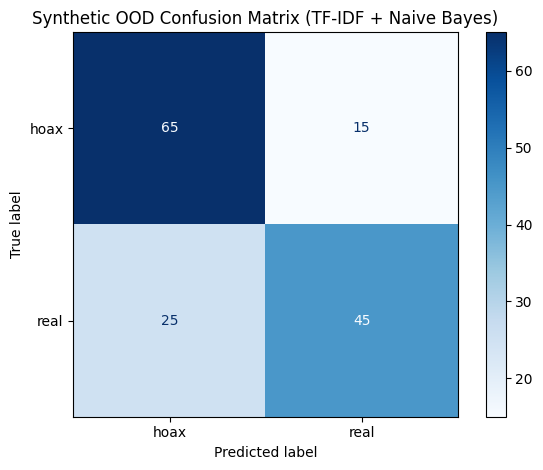

In [3]:
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# load the TF-IDF + Naive Bayes pipeline
with open("tfidf_nb_aug_hoax.pkl", "rb") as f:
    data        = pickle.load(f)
    nb_model    = data["model"]
    vectorizer  = data["vectorizer"]
    stops       = data["stopwords"]
    stemmer     = data["stemmer"]

# define cleaning and tokenization to match training
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# load the synthetic OOD dataset with title, body, label per line
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        title, body, label = line.strip().split("\t")
        titles.append(title)
        bodies.append(body)
        true_labels.append(label)

# preprocess and combine title and body text
texts = [
    " ".join(clean_tokenize(t) + clean_tokenize(b))
    for t, b in zip(titles, bodies)
]

# vectorize into TF-IDF features
X_syn = vectorizer.transform(texts).toarray()

# predict labels on the OOD set
preds = nb_model.predict(X_syn)

# print accuracy and full classification report
print("OOD Results for TF-IDF + Naive Bayes")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

# show the confusion matrix
cm = confusion_matrix(true_labels, preds, labels=["hoax", "real"])
disp = ConfusionMatrixDisplay(cm, display_labels=["hoax", "real"])
disp.plot(cmap="Blues")
plt.title("Synthetic OOD Confusion Matrix (TF-IDF + Naive Bayes)")
plt.tight_layout()
plt.show()
